In [16]:
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
import time
import random
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import requests
import sys
import json
import pickle
from itertools import combinations

from konlpy.tag import Komoran

# bigram 생성에 필요한 library
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# vectorize & lda에 필요한 library
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# gensim의 ldamodel에 최적화된 라이브러리
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

In [17]:
with open('./politics_list.pickle', 'rb') as f:
    politics_list = pickle.load(f)
    
with open('./economy_list.pickle', 'rb') as f:
    economy_list = pickle.load(f)
    
with open('./social_list.pickle', 'rb') as f:
    social_list = pickle.load(f)
    
with open('./lifeculture_list.pickle', 'rb') as f:
    lifeculture_list = pickle.load(f)
    
with open('./global_list.pickle', 'rb') as f:
    global_list = pickle.load(f)
    
with open('./itscience_list.pickle', 'rb') as f:
    itscience_list = pickle.load(f)

In [18]:
politics_list

[['"그래…너네는 총각행세하고 먹튀한 불륜남 전과4범 아니 곧 5범 될 위선자 적폐 사기꾼 인간 말종 쓰레기 희대의 싸이코 패스 욕쟁이 리재명이 뽑아서 공짜밥에 임대주택 살아라… 밑에 두명 자살시키고 대장동 사건 덮으려고 대포폰(?), 추적 안되는 앱으로 통화한 수천억 해처먹은 몸통 아가리 터는 거에 놀아나는 거 봐라. 임기 중에 나라 베네수엘라로 만들고 먹튀한다에 한표"',
  '"난 윤석열 싫어 졌는데  이런일을 보면서  윤석열이  대통령 반드시 되어야  한다는  생각을  다시 하게 되네"',
  '"선관위 대놓고 이재명 편드네~\\n 이재명 욕설이 없는 일이냐?\\n 있는 일 말하는건데 왜 조사?\\n 그럼 김건희 허위 찌라시는 왜 가만 있는데.\\n 벌써 공산화 된거야?"',
  '"무서운 정부네 여기가 공산국가냐. 자유대한민국 어디갔냐"',
  '"형수욕설 댓글단게 무슨 잘못아냐? 대권후보가 형수한테 그런 쌍욕을 해도되냐? 왜 이런 댓글도 못다냐? 없는 일을 지어낸 것도 아닌 원본 내용인데 욕설한 놈이 잘못이지 국민이 무슨 잘못있냐?"',
  '"형수에게 입에담을수없는 욕한자른 대선에 내보낸 민주당 너희가 심판을 받아야지 사실을 얘기한게 죄가되는가?"',
  '"전국민이 아는 사실을 얘기한건데, 수사할 내용이 뭐지? 참 희한한 세상이네"',
  '"군부독재와  박근혜누드그림도 표현의자유라고 얘기하던 인간들이  180석으로  표현의자유도 막아버리는  신독재를하는행태  정권교체해서 상식적인 나라 만듭시다"',
  '"사람이 할 소리가 있고 안 할 소리가 있다 세상살다 별의 별 소리 들었지만 저런 소리 하는 인간이 대한민국 대통령이 된다는 생각은 상상하기도 싫다.."',
  '"선관위가 왜 이런행동을하죠?\\n이재명캠프입니까?"',
  '"욕한걸 욕했다고 하는데,  죄냐?  이게 좌파가 말하는 공정이냐?"',
  '"만일에 없는 말을 지어냈으면 모를까 있는 사실 그대로 썼는데 그걸 고소한다면 언론자유에 심각한 문제이다."',
  '"명확한 녹취내용을 공개

In [23]:
topic_etc_dict=dict()
for i,name in zip(range(6),['politics','economy','social','lifeculture','global','itscience']):
    topic_etc_dict[i]={'topic': name,
        'comments':[]}

In [25]:
for idx, pick in zip(range(6), [politics_list,economy_list,social_list,lifeculture_list,global_list,itscience_list]):
    topic_etc_dict[idx]['comments']=pick
    

In [28]:
with open('./topic_etc_dict.pickle', 'wb') as f:
    pickle.dump(topic_etc_dict, f)

In [29]:
topic_etc_dict

{0: {'topic': 'politics',
  'comments': [['"그래…너네는 총각행세하고 먹튀한 불륜남 전과4범 아니 곧 5범 될 위선자 적폐 사기꾼 인간 말종 쓰레기 희대의 싸이코 패스 욕쟁이 리재명이 뽑아서 공짜밥에 임대주택 살아라… 밑에 두명 자살시키고 대장동 사건 덮으려고 대포폰(?), 추적 안되는 앱으로 통화한 수천억 해처먹은 몸통 아가리 터는 거에 놀아나는 거 봐라. 임기 중에 나라 베네수엘라로 만들고 먹튀한다에 한표"',
    '"난 윤석열 싫어 졌는데  이런일을 보면서  윤석열이  대통령 반드시 되어야  한다는  생각을  다시 하게 되네"',
    '"선관위 대놓고 이재명 편드네~\\n 이재명 욕설이 없는 일이냐?\\n 있는 일 말하는건데 왜 조사?\\n 그럼 김건희 허위 찌라시는 왜 가만 있는데.\\n 벌써 공산화 된거야?"',
    '"무서운 정부네 여기가 공산국가냐. 자유대한민국 어디갔냐"',
    '"형수욕설 댓글단게 무슨 잘못아냐? 대권후보가 형수한테 그런 쌍욕을 해도되냐? 왜 이런 댓글도 못다냐? 없는 일을 지어낸 것도 아닌 원본 내용인데 욕설한 놈이 잘못이지 국민이 무슨 잘못있냐?"',
    '"형수에게 입에담을수없는 욕한자른 대선에 내보낸 민주당 너희가 심판을 받아야지 사실을 얘기한게 죄가되는가?"',
    '"전국민이 아는 사실을 얘기한건데, 수사할 내용이 뭐지? 참 희한한 세상이네"',
    '"군부독재와  박근혜누드그림도 표현의자유라고 얘기하던 인간들이  180석으로  표현의자유도 막아버리는  신독재를하는행태  정권교체해서 상식적인 나라 만듭시다"',
    '"사람이 할 소리가 있고 안 할 소리가 있다 세상살다 별의 별 소리 들었지만 저런 소리 하는 인간이 대한민국 대통령이 된다는 생각은 상상하기도 싫다.."',
    '"선관위가 왜 이런행동을하죠?\\n이재명캠프입니까?"',
    '"욕한걸 욕했다고 하는데,  죄냐?  이게 좌파가 말하는 공정이냐?"',
    '"만일에 없는 말을 지어냈으면 

In [3]:
model_saved = LdaModel.load('./final_model/final_model_pass80.atmodel')

In [4]:
contents_index=all_contents_refined['idx']
all_comments_refined = [x for x,idx in zip(merged['comments'],range(len(merged['comments']))) if idx in contents_index]
all_titles_refined = [x for x,idx in zip(merged['titles'],range(len(merged['titles']))) if idx in contents_index]
all_urls_refined = [x for x,idx in zip(merged['urls'],range(len(merged['urls']))) if idx in contents_index]

In [5]:
topic6_dict=dict()
for i in range(6):
    topic6_dict[i]={'titles':[],
                   'contents':[],
                   'comments':[],
                   'similarity':[],
                   'idx':[]}

In [6]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc): 
            if j == 0:  
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return(topic_table)

In [7]:
topictable = make_topictable_per_doc(model_saved, corpus)
topictable = topictable.reset_index() 
topictable.columns = ['No_document', 'No_topic', 'similarity', 'detail']

In [8]:
for idx,row in topictable.iterrows():
    topic6_dict[int(row['No_topic'])]['titles'].append(all_titles_refined[idx])
    topic6_dict[int(row['No_topic'])]['contents'].append(all_contents_refined['contents'][idx])
    topic6_dict[int(row['No_topic'])]['comments'].append(all_comments_refined[idx])
    topic6_dict[int(row['No_topic'])]['similarity'].append(row['similarity'])
    topic6_dict[int(row['No_topic'])]['idx'].append(idx)

In [15]:
topic6_dict[0]['comments']

[[['"요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인이 무슨 특권도 아니고. 휠체어로 사람치면 그냥 휠체어 몰수하고 지돈으로 사라고 했으면 좋겠다. 젊은 노인들은 휠체어타고 다니고 80노인은 걸어다니고 실제 걷지를 못하는지 제대로된 검증도 필요하다."',
   '"ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ"',
   '"저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에"',
   '"장애가 권리고 벼슬인 사람들이 있습니다"',
   '"수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장애인들이 이용하는거라 잘 모르시겠지만 10년전에도 있던겁니다. 중국산이 많아 배터리 안정성이나 인증받은 제품이 없을거같네요. 제대로된 전동휠체어는 장애인등록및기준에 합당해야하는데 그 기준에 합당하지않은데 기능장애 있는분들이 주로 씁니다."',
   '"자동차도 아니고 자전거도 아닌 전동킥보드가 차도에서는 운전자에게 위협이 되고 보도에서는 보행자에게 위협이 된다. 정부는 전동킥보드를 완전 폐지해야 한다"',
   '"타고다니는건 좋으나 제발 주의살피며 천천히 다녀주세요. 자전거, 전동 킥보드 기타 외 타고다는 것들은 모두 주의해야합니다."',
   '"점점승용차운전하기힘들어진다"',
   '"한 변호사님 당황하는 표정ㅋㅋㅋ"',
   '"장애인전동카트 상당수가 비장애인입니다. 과속은 물론 팔걸이에 여자를 태우기도 하고 자기들 끼리 드리프트도 하고 야간에 도로에서 조명은 커녕 반사판 하나없이 주행하는거 보면 정말 아찔합니다. 지하상가에서 경적울리며 달리기도 하고 아주 개판인데 음주운전까지 하네요..무법천지죠."',
   '"저런거 차에 치이면 확인 사살 하는게 싸게 먹힌다"',
   '"전킥 속도제한 풀어서 속도내는 사람 많음"',
   '"전동 휠체어보다 싸것네"',
   '"애자들이 저렇게다니는데는 이유가있지.....그러니 휠체어타고다니는거다"',
   '"한 변호사님 와~우!! ㅋㅋ"',
   '"오 와우옼

In [10]:
with open('./topic6_dict.pickle', 'wb') as f:
    pickle.dump(topic6_dict, f)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


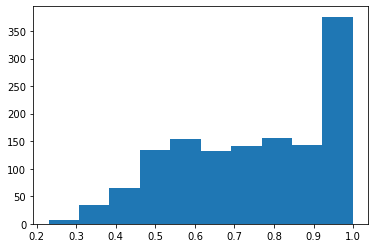

In [11]:
plt.hist(topictable['similarity'])
plt.show()

KeyError: 'No_topics'

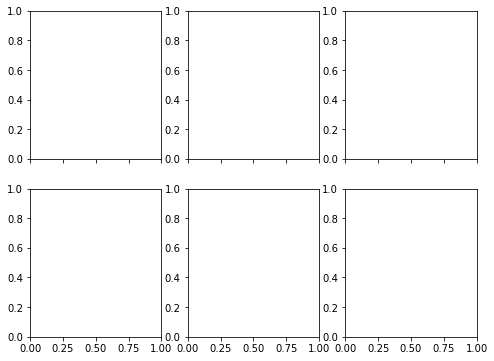

In [12]:
f, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)

for i in range(2):
    for j in range(3):
        df = pd.DataFrame(topic6_dict['No_topics']).value_counts()
        df.plot.pie(autopct='%.2f%%', ax= axes[i,j])
                
plt.show()

In [13]:
model_saved.print_topics(num_words=20) 

[(0,
  '0.018*"전동킥보드" + 0.016*"견인" + 0.015*"공유" + 0.014*"주차" + 0.013*"업체" + 0.011*"자전거" + 0.011*"서울시" + 0.009*"불법" + 0.009*"구역" + 0.007*"안전" + 0.007*"도로" + 0.007*"방치" + 0.007*"주행" + 0.007*"이용" + 0.006*"PM" + 0.006*"인도" + 0.006*"보행자" + 0.006*"문제" + 0.005*"시행" + 0.005*"관련"'),
 (1,
  '0.023*"충전" + 0.021*"제품" + 0.018*"배터리" + 0.015*"화재" + 0.012*"발생" + 0.009*"전동킥보드" + 0.008*"사고" + 0.007*"아파트" + 0.007*"기준" + 0.007*"소방" + 0.006*"조사" + 0.006*"언론" + 0.006*"표시" + 0.006*"피해" + 0.006*"소비자" + 0.006*"공감" + 0.006*"판매" + 0.006*"공감_언론" + 0.006*"무단" + 0.005*"가격"'),
 (2,
  '0.025*"사고" + 0.021*"경찰" + 0.013*"면허" + 0.012*"전동킥보드" + 0.012*"운전자" + 0.012*"음주운전" + 0.011*"음주" + 0.010*"상태" + 0.008*"운전" + 0.008*"도로" + 0.008*"도로교통법" + 0.008*"처벌" + 0.008*"차량" + 0.007*"자전거" + 0.007*"취소" + 0.007*"자동차" + 0.007*"남성" + 0.006*"혐의" + 0.006*"단속" + 0.006*"장치"'),
 (3,
  '0.027*"사고" + 0.025*"보험" + 0.013*"이동" + 0.011*"가입" + 0.011*"전동킥보드" + 0.010*"수단" + 0.010*"자동차" + 0.009*"업체" + 0.009*"경우" + 0.009*"보상" + 0.008*"발생" + 0.008*"공유" +